<img src="banner.png" width=500 style="margin-left:0; margin-right:auto; padding: 20px"/>

This notebook provides an introduction to ExoMDN, a machine-learning based model for the rapid characterization of exoplanet interiors. ExoMDN is based on Mixture Density Networks (MDNs), which output a mixture of Gaussian functions in order to approximate the distribution of interior structures which fit e.g. observed planet mass and planet radius.

For more details, see Baumeister et al. 2023

Contact: <philipp.baumeister@dlr.de>

In [1]:
from exomdn import ExoMDN
from exomdn.plotting import cornerplot, cornerplot_logratios

2023-02-07 16:39:50.150496: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Setting up
</br>
Let's start by creating a new <code>ExoMDN</code> object. <code>ExoMDN</code> handles the MDN models and includes interactive widgets to facilitate loading models and running predictions.

In [2]:
exomdn = ExoMDN()

# Loading a trained model
</br>
Next, we need to load a trained MDN model which we want to use for the interior prediction. To simplify things, we will use the included <code>load_model_widget</code>, which allows to interactively select which model to load. By default, <code>ExoMDN</code> searches for models in the  <i>./models</i> path. This can be changed by setting <code>exomdn.model_path</code>

By default, two models are available:

* ***mass_radius_Teq*** (takes planet mass, radius, and equilibrium temperature as inputs)
* ***mass_radius_k2_Teq*** (takes planet mass, radius, fluid Love number $k_2$ and equilibrium temperature as inputs)

In [3]:
exomdn.load_model_widget

LoadModelWidget(children=(Label(value='Select model:'), Select(layout=Layout(width='50%'), options=('mass_radi…

# Making an interior prediction
</br>
<code>ExoMDN</code> provides a custom widget to run a prediction for a single planet. The output of the MDN is in terms of a distribution of log-ratios of the mass and radius fractions of each interior layer of the planet. To convert to mass and radius fractions, the model samples from the distribution and transforms each point. The number of samples can be specified in the "Options" section of the widget.
</br>
</br>
Uncertainties can be included by ticking the checkbox in "Planet parameters". The model then first samples a number of times from within the error bars (how often can be set with the "Uncertainty samples" option) and predicts an interior distribution from each. From each of these predictions a number of points is then sampled so that the total number fits as closely as possible to the specified total number of samples (e.g. with the default values of 10 000 total samples and 1000 uncertainty samples, the model predicts 1000 distributions from within the error bars and then samples 10 times from each predicted distribution to get to the total of 10 000)

In [4]:
exomdn.prediction_widget

PredictionWidget(children=(Accordion(children=(VBox(children=(HBox(children=(Select(layout=Layout(height='200p…

The output of the prediction widget is saved in <code>ExoMDN</code> in the form of [pandas DataFrames](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) as follows:

* `exomdn.input_prompt` contains the input(s) to the prediction
* `exomdn.prediction` contains the predicted samples of the interior
* `exomdn.mixture_components` contains the means, variances, and mixture weights of the predicted Gaussian mixture

In [5]:
print(f"Length of input: {len(exomdn.input_prompt)}")
print(f"Number of mixture components: {len(exomdn.mixture_components)}")
print("=" * 40)
print("Prediction Summary:")
exomdn.prediction.describe()

Length of input: 1
Number of mixture components: 50
Prediction Summary:


,log_d_mantle_core,log_d_ice_core,log_d_atmosphere_core,log_m_mantle_core,log_m_ice_core,log_m_atmosphere_core,prediction,mantle_rf,ice_rf,atmosphere_rf,core_rf,mantle_mf,ice_mf,atmosphere_mf,core_mf
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.0,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000
mean,-1.805313,-2.271092,-2.605716,-1.553854,-2.758912,-14.466726,0.0,0.154079,0.098779,0.061876,0.685267,0.211076,0.067886,1.443115e-05,0.721024
std,1.000422,0.969848,0.625205,1.131045,1.079331,2.502151,0.0,0.099304,0.064618,0.037959,0.044864,0.141830,0.047824,7.339376e-05,0.118915
min,-6.507470,-8.385452,-4.160044,-6.715383,-10.106428,-19.109564,0.0,0.001082,0.000162,0.010215,0.528678,0.000975,0.000029,4.069090e-09,0.354298
25%,-2.283836,-2.732680,-3.068863,-2.152903,-3.227136,-16.458783,0.0,0.072888,0.043624,0.030883,0.657458,0.094357,0.026713,4.659691e-08,0.642111
50%,-1.592625,-2.025172,-2.532177,-1.372246,-2.469703,-14.976287,0.0,0.141374,0.091068,0.054015,0.690690,0.188741,0.060307,2.176391e-07,0.735597
75%,-1.083208,-1.562326,-2.099825,-0.736543,-1.970631,-12.886363,0.0,0.223454,0.147323,0.086830,0.716999,0.308599,0.102783,1.998769e-06,0.807375
max,-0.255237,-0.960833,-1.327622,0.579571,-1.378527,-6.134221,0.0,0.421869,0.268083,0.203065,0.834074,0.632519,0.199089,1.995006e-03,0.992183


# Visualization

We can visualize the output of the MDN with the `cornerplot_logratios` function. It takes as input the prediction data, the mixture components, and the log-ratio data columns one wants to visualize (' (`exomdn.rf_logratios` for radius fractions, `exomdn.mf_logratios` for mass fractions, `exomdn.logratios` for both).

The upper right plots also show the distribution of Gaussian kernels as predicted by the MDN, where the colors mark the respective weight in the distribution.

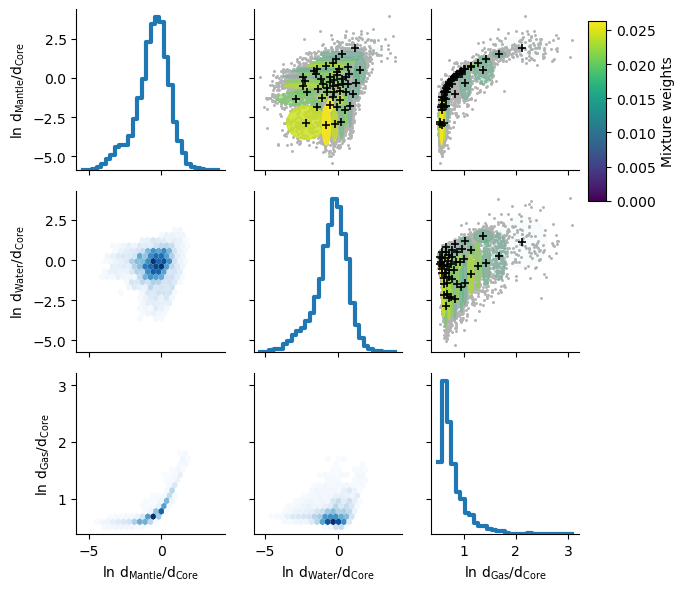

In [13]:
# showing radius fractions
cornerplot_logratios(data=exomdn.prediction, data_components=exomdn.mixture_components, columns=exomdn.rf_logratios, height=2)

# showing mass fractions
# cornerplot_logratios(data=exomdn.prediction, data_components=exomdn.mixture_components, columns=exomdn.mf_logratios, height=2)

# showing both radius and mass fractions
# cornerplot_logratios(data=exomdn.prediction, data_components=exomdn.mixture_components, columns=exomdn.logratios, height=1.5)

The `cornerplot` function can be used to show the predicted interior in terms of true radius and mass fractions instead of log-ratios.

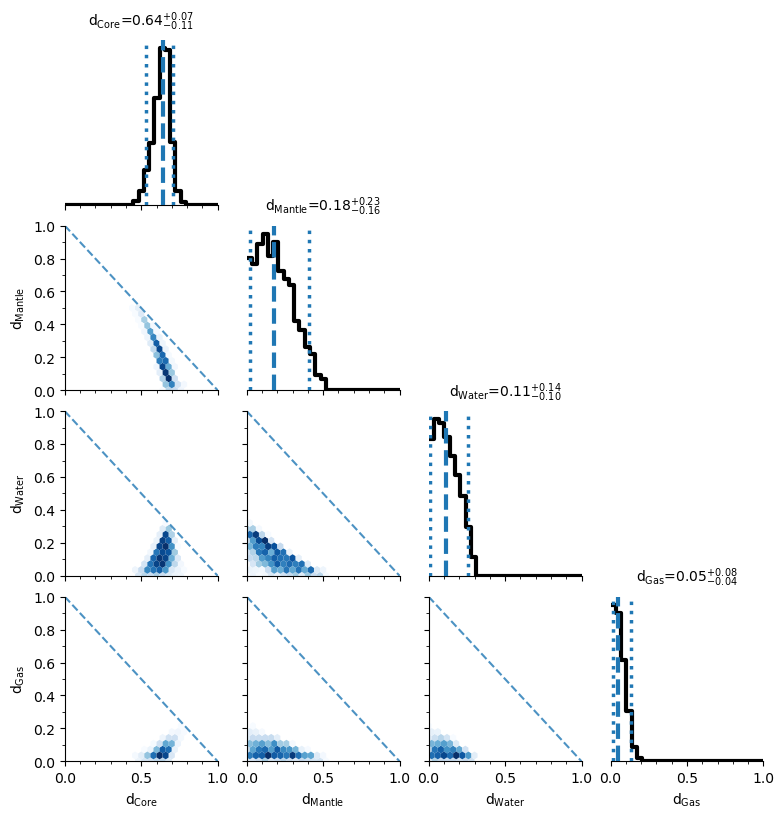

In [46]:
# showing radius fractions
cornerplot(data=exomdn.prediction, columns=exomdn.rf, height=2)

# showing mass fractions
# cornerplot(data=exomdn.prediction, columns=exomdn.mf, height=2)